# Proyecto: Salarios en la ciencia de datos

**Presentación & propósito**

Análisis del dataset `ds_salaries.csv`. Este conjunto de datos reúne reportes salariales para roles de Data & AI (principalmente 2023). Su objetivo es permitir benchmarking, análisis de mercado y preparar los datos para modelos predictivos de salario.

Resumen:
- Cobertura temporal: 2020–2023 (predominantemente 2023).
- Ámbito: salarios por rol, convertidos a USD (`salary_in_usd`) junto con moneda original (`salary_currency`).
- Dimensiones clave: `job_title`, `experience_level`, `employee_residence`, `company_location`, `remote_ratio`, `company_size`.

Riesgos y consideraciones:
- Revisar conversiones de moneda y outliers (p.ej. salarios en INR con cifras locales altas pero `salary_in_usd` bajas).
- Homogeneizar `job_title` en familias para análisis robustos.

## Tabla de variables

A continuación se presenta una tabla con las variables del dataset, su tipo, una breve descripción, un ejemplo y notas de calidad.

| Variable | Tipo | Descripción | Ejemplo | Notas |
|---|---:|---|---|---|
| `work_year` | int | Año del reporte salarial | `2023` | Uso para análisis temporal; pocos años presentes |
| `experience_level` | categoría (EN/MI/SE/EX) | Nivel de experiencia del empleado | `SE` | Mapear a orden: EN < MI < SE < EX |
| `employment_type` | categoría (FT/CT/FL/PT) | Tipo de contratación | `FT` | Normalizar etiquetas |
| `job_title` | string | Título del puesto | `Data Scientist` | Agrupar en `job_family` para análisis agregados |
| `salary` | float | Salario en moneda local | `1650000` (INR) | No comparar directamente entre monedas |
| `salary_currency` | string | Código ISO de moneda | `INR`, `USD`, `EUR` | Validar consistencia (3 letras) |
| `salary_in_usd` | float | Salario convertido a USD | `20984` | Usar para comparaciones internacionales |
| `employee_residence` | string (ISO país) | País de residencia del empleado | `IN` | Validar códigos y homogeneizar |
| `remote_ratio` | int (0/50/100) | Porcentaje de trabajo remoto | `100` | Mapear a `remote`/`hybrid`/`on-site` |
| `company_location` | string (ISO país) | País de la sede de la compañía | `US` | Comparar con `employee_residence` |
| `company_size` | categoría (S/M/L) | Tamaño aproximado de la empresa | `L` | Evaluar impacto en salario |

**Notas adicionales:**
- Se recomienda crear una columna `job_family` que agrupe títulos similares (p.ej. "Data Scientist", "Applied Scientist" → "Data Scientist").
- Marcar y revisar filas con `salary_in_usd <= 1000` o `salary_in_usd > 1_000_000` como posibles outliers.
- Documentar cualquier regla de limpieza en el notebook para reproducibilidad.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [3]:
df = pd.read_csv('ds_salaries.csv')
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


### Preprocesamiento de datos: ¿Qué estamos haciendo y por qué?


Primero, ¿qué buscamos con estas celdas iniciales?
- Realizar controles básicos de calidad (sanity checks) para entender la estructura del dato y detectar problemas evidentes.
- Limpiar el dataset de artefactos simples (como duplicados idénticos) que podrían sesgar estadísticas en el EDA.
- Documentar cada decisión para mantener trazabilidad y facilitar revisiones posteriores.

Qué hace cada bloque y por qué lo hacemos

1) Comprobación de valores faltantes (`df.isnull().sum()`)

Al ejecutar esta celda obtenemos el conteo de valores ausentes por columna. Esto nos permite priorizar columnas que necesitan atención: por ejemplo, si `salary_in_usd` tiene valores faltantes deberemos decidir entre imputar o descartar esos registros. Este chequeo es informativo: no modificamos datos todavía, sólo registramos el estado actual para decidir la estrategia más adecuada.

2) Inspección del tamaño del dataset (`df.shape`)

Conocer el número de filas y columnas nos da contexto del alcance del análisis. Cada transformación posterior (filtrado, eliminación de duplicados) reducirá el número de observaciones; por eso registrar el `shape` antes y después es fundamental para cuantificar el impacto y justificar decisiones de limpieza ante stakeholders.

3) Detección de duplicados (`df.duplicated().sum()`)

Aquí detectamos cuántas filas son exactamente iguales en todas sus columnas. Los duplicados exactos suelen ser errores de integración o exportación. Saber su número nos permite decidir si proceder a una eliminación masiva (cuando es seguro) o a una revisión más cuidadosa (cuando sospechamos que registros idénticos podrían corresponder a transacciones distintas).

4) Eliminación de duplicados exactos (`df = df.drop_duplicates()`)

Decidimos eliminar duplicados exactos en esta fase por ser una acción de bajo riesgo que mejora la calidad del dataset sin introducir suposiciones de negocio. El criterio: sólo filas idénticas en todas las columnas son removidas.

Buenas prácticas asociadas a esta decisión:
- Antes de borrar, recomendamos inspeccionar una muestra de duplicados para asegurarnos de que no haya casos legítimos repetidos por razones de negocio.
- Si existe una clave de negocio (por ejemplo `employee_id` y `timestamp`), la desduplicación debería basarse en un subconjunto de columnas en vez de eliminar por fila completa.
- Guardar las filas eliminadas en un archivo (p.ej. `duplicates_removed.csv`) para auditoría.

5) Verificación posterior (re-ejecutar `df.shape` y `df.duplicated().sum()`)

Finalmente, re-ejecutamos las comprobaciones para confirmar el efecto de la limpieza. Esto nos proporciona evidencia cuantitativa (cuántas filas se eliminaron) y asegura que la operación tuvo el efecto esperado.

In [4]:
df.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [5]:
df.shape

(3755, 11)

In [6]:
df.duplicated().sum()

1171

In [7]:
#remove the duplicates
df = df.drop_duplicates()

In [8]:
df.shape

(2584, 11)

In [9]:
df.duplicated().sum()

0

### EDA

## Detección y tratamiento de outliers

En esta sección aplicamos varias técnicas complementarias para identificar y entender valores atípicos (outliers) en el dataset. Los outliers pueden reflejar errores, casos raros pero reales, o segmentos de negocio con comportamientos distintos. Usaremos enfoques univariados (IQR/boxplots), estandarización (Z-score) y un método multivariante basado en árboles (Isolation Forest). Cada técnica aporta una perspectiva diferente:
- Univariante (IQR): robusto, no asume normalidad; bueno para detectar extremos por variable.
- Z-score: útil en distribuciones aproximadamente normales; simple de interpretar.
- Isolation Forest: captura anomalías multivariadas y no necesita supuestos fuertes sobre la distribución.

A continuación, antes de cada bloque de código, se incluye un resumen que explica la técnica, cómo interpretarla, los resultados esperados y cuándo conviene usarla.

In [10]:
df.dtypes

work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object

## Distribución de variables numéricas

A continuación se presentan los histogramas de las cuatro variables numéricas principales del dataset:

- **work_year**: Concentración en 2022-2023, pocos datos históricos
- **salary**: Valores en moneda local (escala heterogénea según país)
- **salary_in_usd**: Distribución sesgada hacia la derecha, mayoría entre 50k-160k USD
- **remote_ratio**: Principalmente categórica (0%, 50%, 100% remoto)

### Observaciones detalladas por variable numérica

**work_year**
- Distribución: picos en 2022 y 2023; pocos registros en 2020/2021.
- Implicación: mayoría del análisis representará 2023 — cuidado al generalizar tendencias temporales con pocos años.

**salary (moneda local)**
- Observación: escala heterogénea (ej. millones en INR frente a decenas de miles en USD/EUR).
- Problema: no usar salary directamente para comparar países sin convertir; además hay registros cuyo salary parece extremadamente alto por la moneda local (pero su salary_in_usd está dentro de un rango razonable), lo que indica conversiones hechas correctamente pero números base muy grandes por moneda.
- Acción: usar solo salary_in_usd para análisis multicountry; mantener salary solo si se necesitan análisis por moneda local o ajustes por coste de vida.

**salary_in_usd**
- Forma: distribución sesgada a la derecha. La mayor densidad parece entre ~50k y ~160k USD; hay colas hasta >300–400k.
- Riesgos: la media probablemente esté por encima de la mediana por la influencia de outliers. Recomendación: usar mediana y percentiles para resumen (p50, p25, p75, p90).
- Outliers: marcar registros con salary_in_usd <= 1000 (probablemente errores) y salary_in_usd > 1_000_000 (improbables) para revisión manual.
- Visual: usar histograma con escala log y boxplot para entender cola y presencia de outliers.

**remote_ratio**
- Distribución: concentrada principalmente en 0 y 100, con algunos registros en 50.
- Interpretación: la variable es esencialmente categórica (on-site/hybrid/remote); convertir a labels mejora legibilidad.

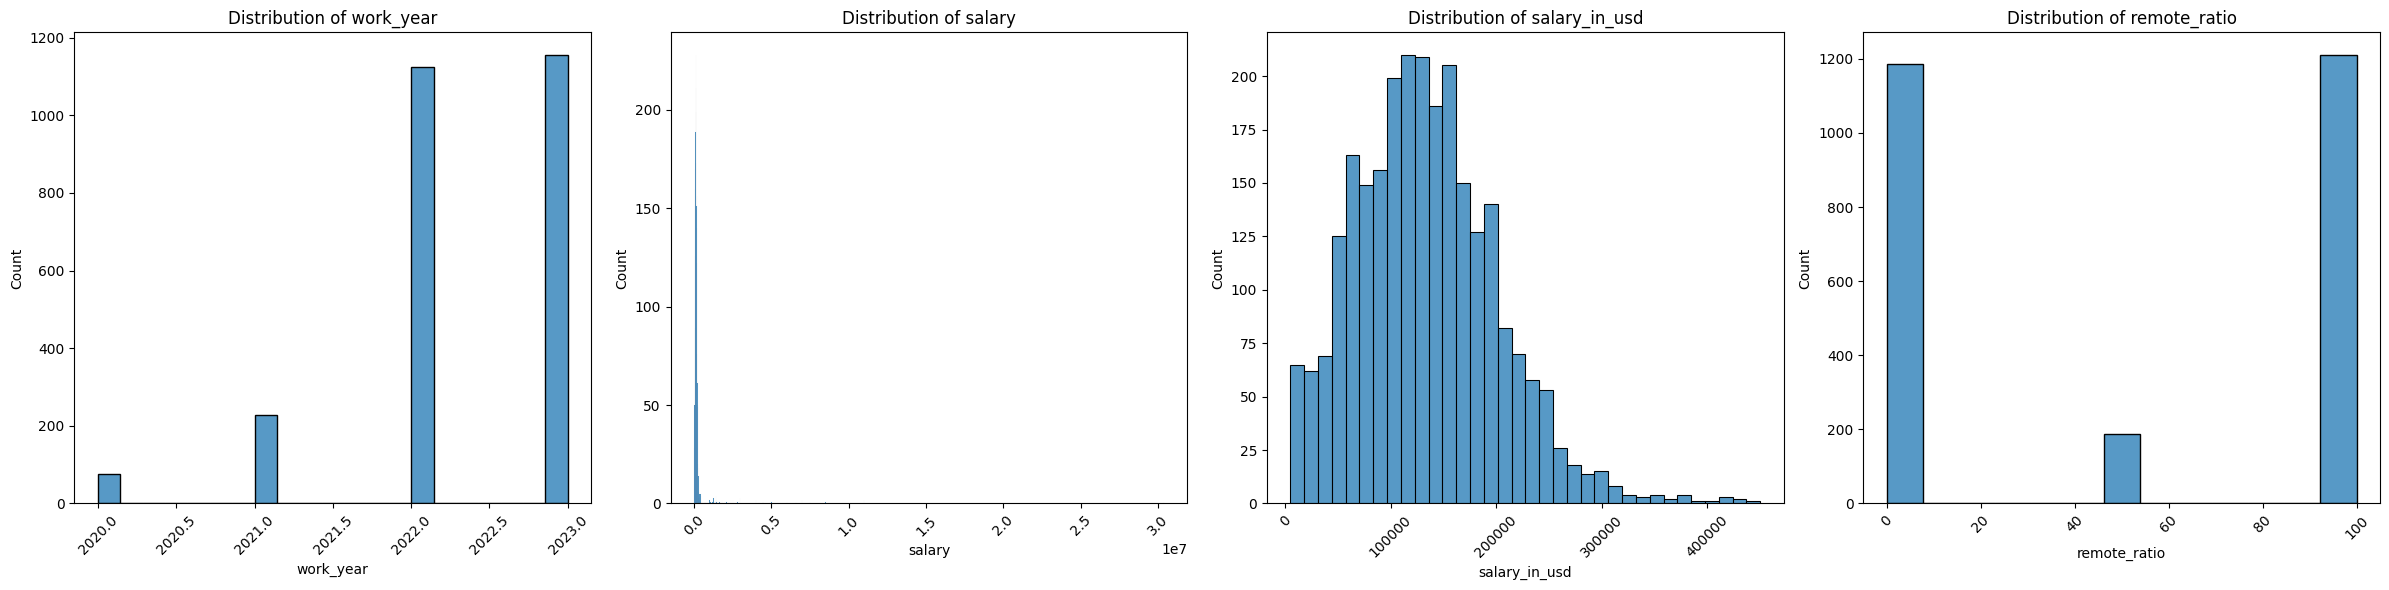

In [11]:
cols = ["work_year", "salary", "salary_in_usd", "remote_ratio"]
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(24, 6))

for i, col in enumerate(cols):
    sns.histplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

experience_level: 4 valores únicos
employment_type: 4 valores únicos
job_title: 93 valores únicos
salary_currency: 20 valores únicos
employee_residence: 78 valores únicos
company_location: 72 valores únicos
company_size: 3 valores únicos

Variables con alta cardinalidad (>10 valores): ['job_title', 'salary_currency', 'employee_residence', 'company_location']


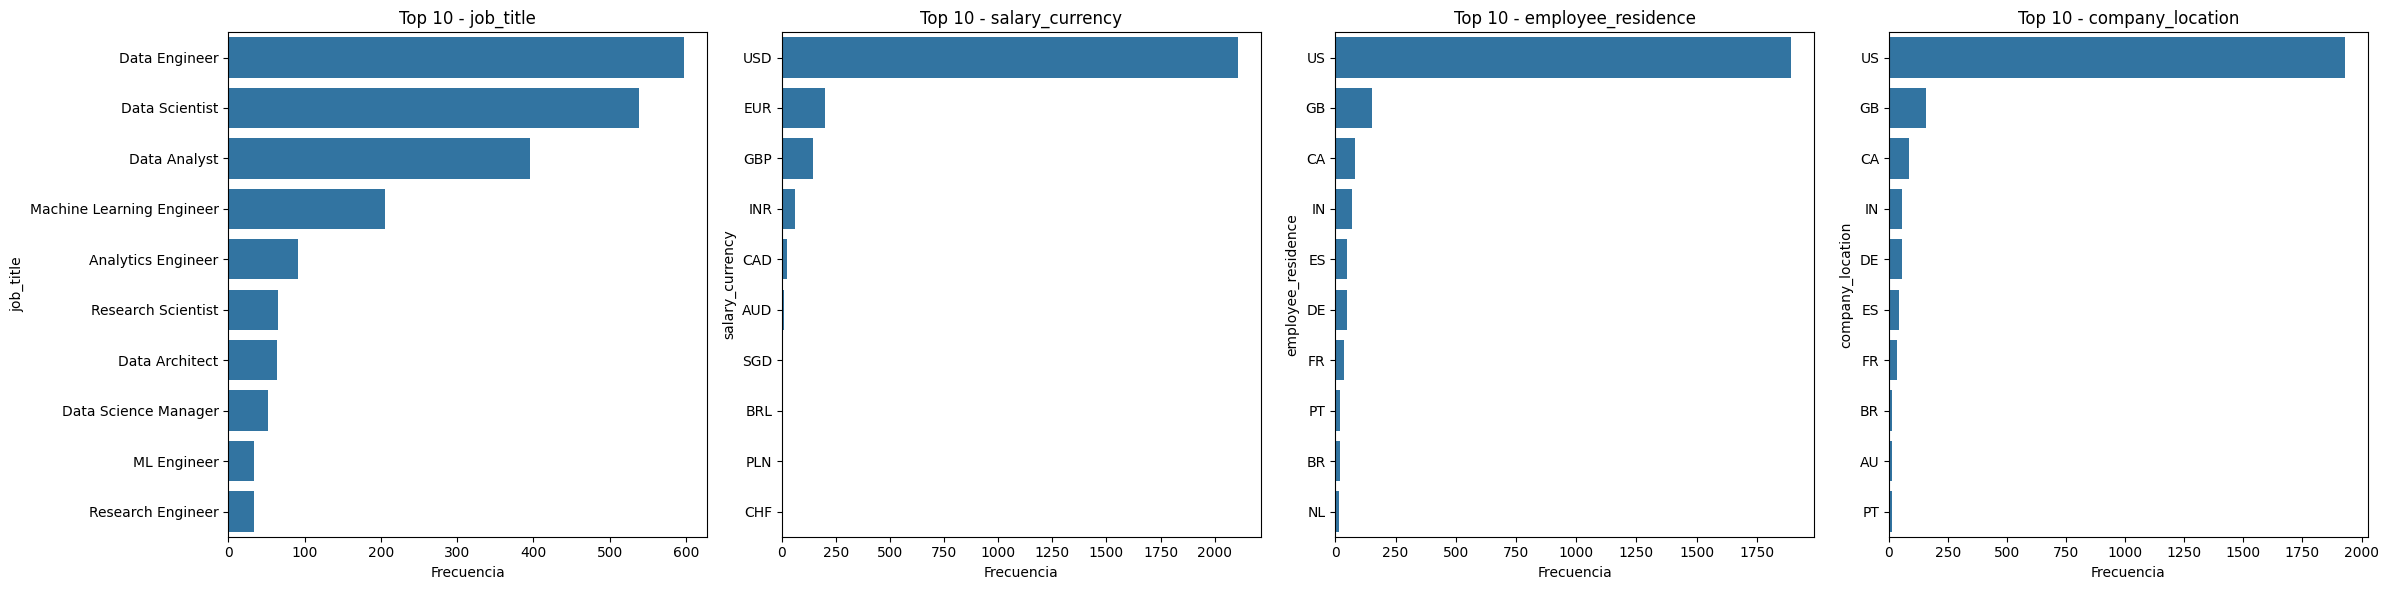

In [12]:
# Identificar variables categóricas con muchos valores únicos
categorical_cols = ["experience_level", "employment_type", "job_title", "salary_currency", "employee_residence", "company_location", "company_size"]

# Verificar cuántos valores únicos tiene cada variable
for col in categorical_cols:
    unique_count = df[col].nunique()
    print(f"{col}: {unique_count} valores únicos")

# Variables con muchos valores únicos (>10) - crear top 10
high_cardinality_cols = []
for col in categorical_cols:
    if df[col].nunique() > 10:
        high_cardinality_cols.append(col)

print(f"\nVariables con alta cardinalidad (>10 valores): {high_cardinality_cols}")

# Crear gráficos de top 10 para variables con alta cardinalidad
if high_cardinality_cols:
    n_cols = len(high_cardinality_cols)
    fig, axes = plt.subplots(nrows=1, ncols=n_cols, figsize=(6*n_cols, 6))
    
    if n_cols == 1:
        axes = [axes]
    
    for i, col in enumerate(high_cardinality_cols):
        top_10 = df[col].value_counts().head(10)
        sns.barplot(x=top_10.values, y=top_10.index, ax=axes[i])
        axes[i].set_title(f'Top 10 - {col}')
        axes[i].set_xlabel('Frecuencia')
        axes[i].set_ylabel(col)
    
    plt.tight_layout()
    plt.show()

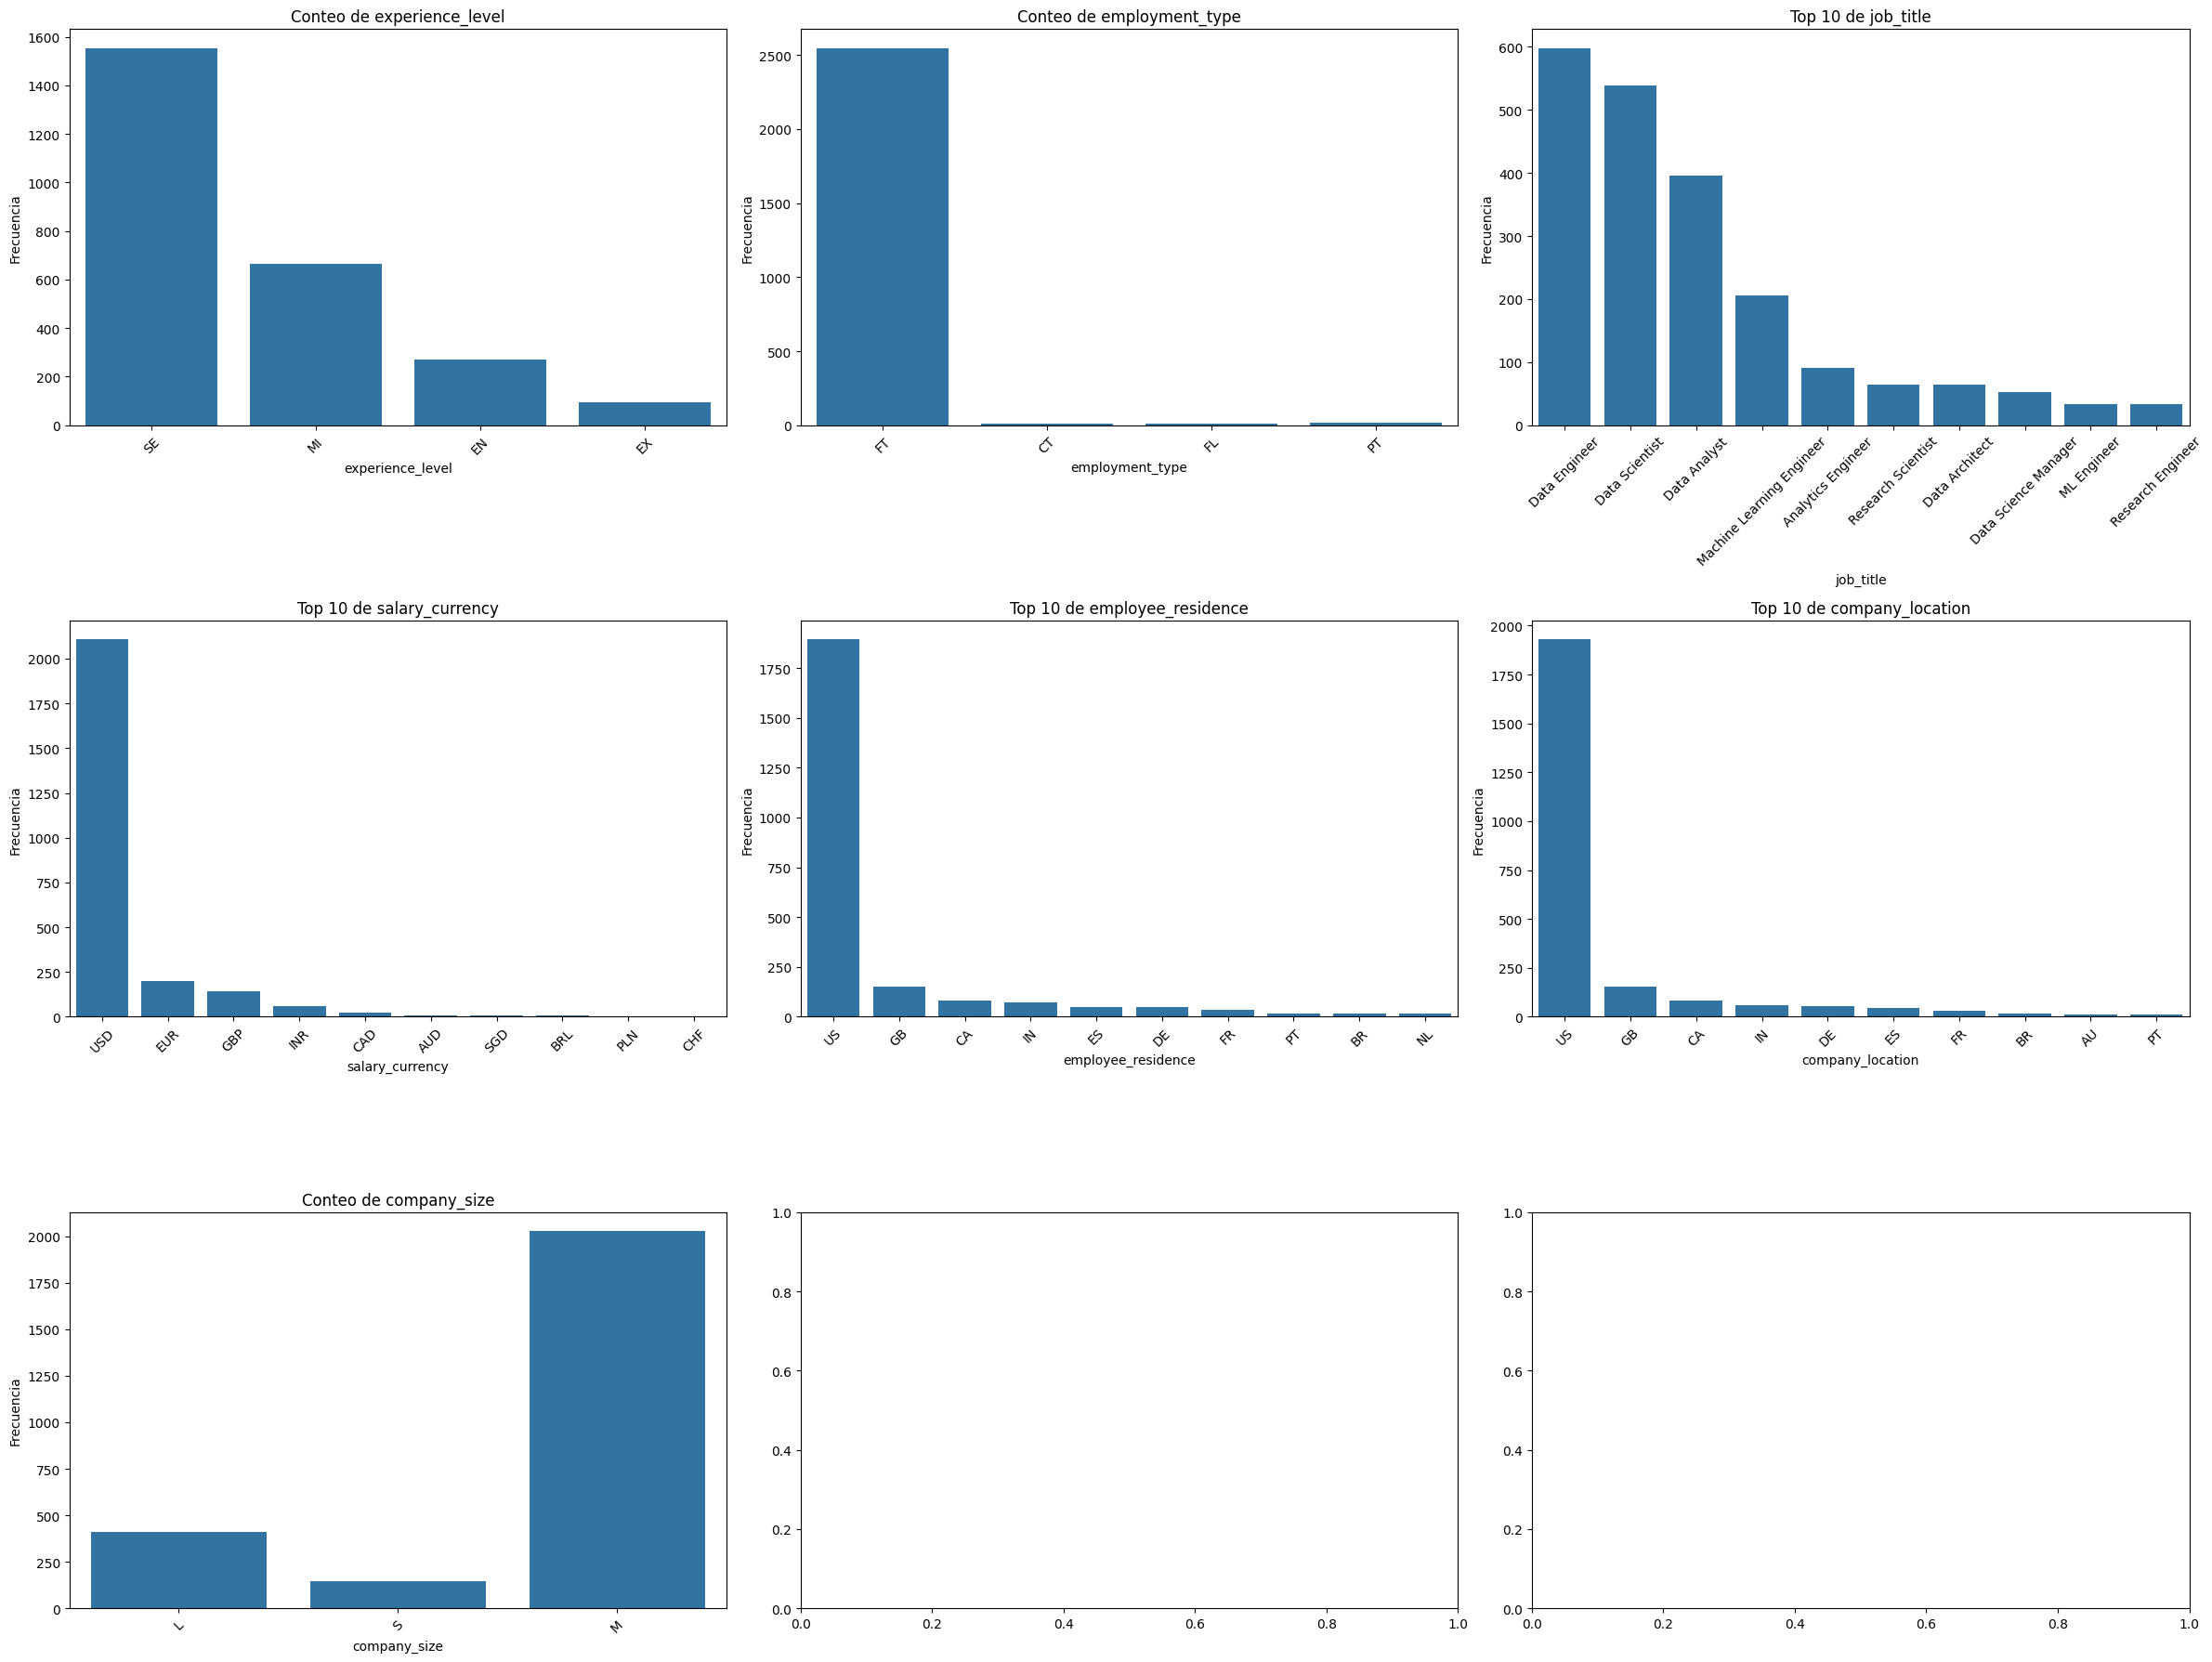

In [13]:
cols = ["experience_level", "employment_type", "job_title", "salary_currency", "employee_residence", "company_location", "company_size"]
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(24, 18))

for ax, col in zip(axes.flatten(), cols):
    n_unique = df[col].nunique()
    if n_unique > 15:  # Umbral para considerar "masiva"
        top10 = df[col].value_counts().nlargest(10)
        sns.barplot(x=top10.index, y=top10.values, ax=ax)
        ax.set_title(f'Top 10 de {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frecuencia')
        ax.tick_params(axis='x', rotation=45)
    else:
        sns.countplot(data=df, x=col, ax=ax)
        ax.set_title(f'Conteo de {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frecuencia')
        ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Técnica 1: Boxplots e IQR (rango intercuartílico)

- Análisis: evaluamos cada variable numérica de forma univariada para detectar valores alejados de la mediana y de los cuartiles.
- Técnica: el método IQR define límites típicos: [Q1 − 1.5·IQR, Q3 + 1.5·IQR]. Valores fuera de ese rango son potenciales outliers.
- Explicación: es robusto frente a distribuciones sesgadas y no asume normalidad; ideal como primer filtro.
- Resultados: boxplots por variable y conteo de observaciones fuera de los límites IQR; estos puntos deben revisarse (no eliminarse automáticamente).
- Cuándo usarlo: cuando queremos una detección simple, interpretable y resistente a la asimetría de la distribución.


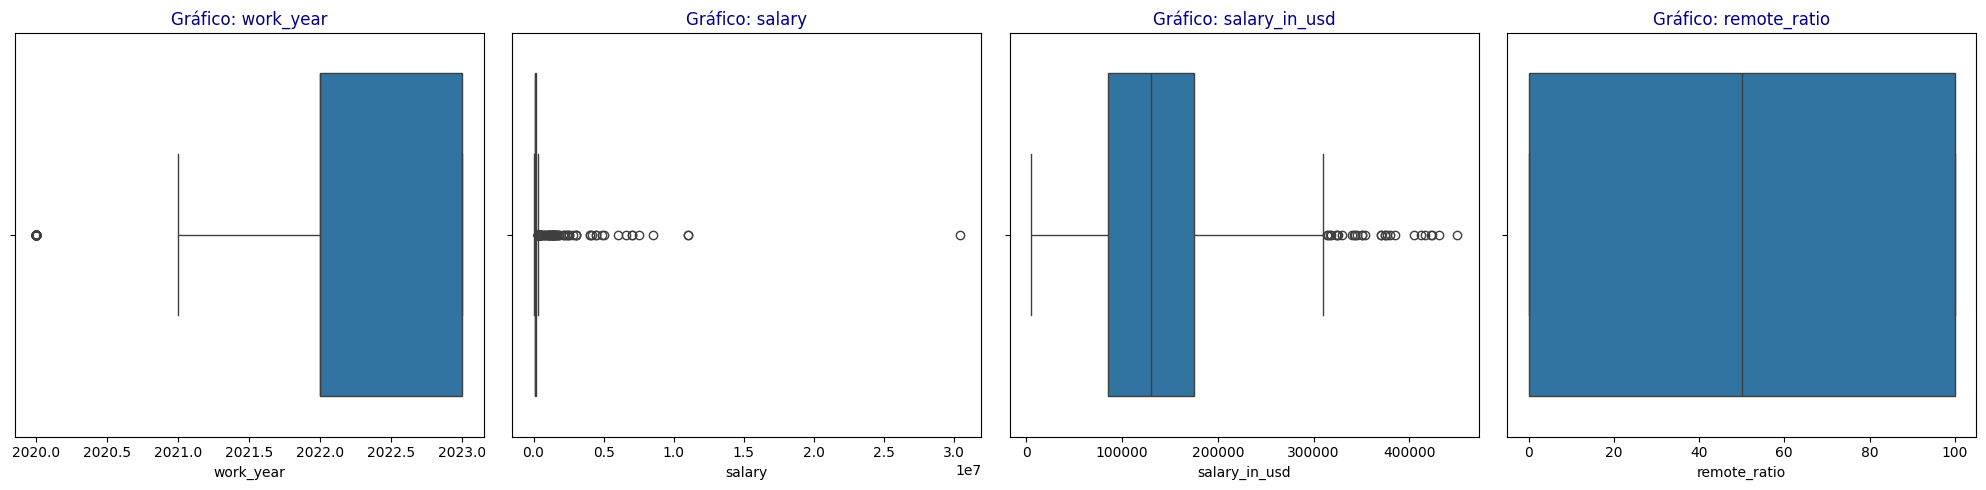

In [14]:
import math
def identificar_outliers(dataframe):
    """
    Esta función crea un gráfico de caja (boxplot) para cada columna numérica 
    en un DataFrame para ayudar a identificar los outliers.
    """
    # Seleccionamos solo las columnas numéricas
    numeric_cols = dataframe.select_dtypes(include=np.number).columns

    # Creamos los subplots
    ncols = 4
    nrows = math.ceil(len(numeric_cols) / ncols) 
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5*nrows))

    # Si el dataframe tiene menos de 4 columnas numéricas, axes no será una lista de listas, por lo que se convierte en una para poder iterar
    if nrows == 1 or ncols == 1:
        axes = [axes]

    for i, col in enumerate(numeric_cols):
        row = i // ncols
        col_idx = i % ncols
        # Comprueba si la columna tiene más de un valor único para evitar errores
        if len(dataframe[col].unique()) > 1:
            sns.boxplot(x=dataframe[col], data=dataframe, ax=axes[row][col_idx])
            axes[row][col_idx].set_title(f"Gráfico: {col}", color="DarkBlue")
        else:
            print(f"La columna {col} tiene un solo valor único y no se puede graficar")

    plt.tight_layout()
    plt.show()

identificar_outliers(df)


### Técnica 2: Z-score (estandarización)

- Análisis: medimos cuántos desvíos estándar se aleja cada valor de la media en cada variable numérica.
- Técnica: calculamos el Z-score y marcamos como outliers los valores con |Z| > umbral (típicamente 3.0).
- Explicación: asume (aproximadamente) normalidad; es sensible a colas pesadas, por lo que conviene combinarlo con métodos robustos.
- Resultados: resumen por columna con cantidad/porcentaje de outliers y rangos extremos detectados.
- Cuándo usarlo: cuando la variable es cercana a normal o queremos una regla simple y consistente para cribar valores extremos.


In [15]:
from scipy import stats

def identificar_outliers_zscore(dataframe, threshold=3):
    """
    Identifica outliers usando el método Z-score para columnas numéricas.
    
    Parámetros:
    - dataframe: DataFrame de pandas
    - threshold: umbral del Z-score (por defecto 3, valores típicos: 2.5-3.5)
    
    Retorna:
    - DataFrame con información de outliers por columna
    - Diccionario con índices de outliers por columna
    """
    
    # Seleccionar solo columnas numéricas
    numeric_cols = dataframe.select_dtypes(include=np.number).columns
    
    outliers_info = {}
    outliers_indices = {}
    
    print(f"Identificando outliers con Z-score > {threshold}\n")
    print("="*60)
    
    for col in numeric_cols:
        # Calcular Z-score
        z_scores = np.abs(stats.zscore(dataframe[col]))
        
        # Identificar outliers
        outlier_mask = z_scores > threshold
        outlier_indices = dataframe[outlier_mask].index.tolist()
        
        # Guardar información
        outliers_indices[col] = outlier_indices
        outliers_info[col] = {
            'total_outliers': len(outlier_indices),
            'percentage': (len(outlier_indices) / len(dataframe)) * 100,
            'min_outlier': dataframe.loc[outlier_indices, col].min() if outlier_indices else None,
            'max_outlier': dataframe.loc[outlier_indices, col].max() if outlier_indices else None,
            'outlier_indices': outlier_indices[:10]  # Mostrar solo los primeros 10
        }
        
        # Imprimir resumen
        print(f"Columna: {col}")
        print(f"  - Outliers encontrados: {outliers_info[col]['total_outliers']}")
        print(f"  - Porcentaje: {outliers_info[col]['percentage']:.2f}%")
        if outlier_indices:
            print(f"  - Rango outliers: [{outliers_info[col]['min_outlier']:.0f} - {outliers_info[col]['max_outlier']:.0f}]")
            print(f"  - Primeros índices: {outliers_info[col]['outlier_indices']}")
        print("-" * 40)
    
    return outliers_info, outliers_indices

# Ejecutar la función
outliers_info, outliers_indices = identificar_outliers_zscore(df, threshold=3)

Identificando outliers con Z-score > 3

Columna: work_year
  - Outliers encontrados: 75
  - Porcentaje: 2.90%
  - Rango outliers: [2020 - 2020]
  - Primeros índices: [183, 2118, 3119, 3138, 3163, 3419, 3446, 3455, 3506, 3514]
----------------------------------------
Columna: salary
  - Outliers encontrados: 20
  - Porcentaje: 0.77%
  - Rango outliers: [2800000 - 30400000]
  - Primeros índices: [1462, 1738, 1868, 1946, 2358, 2655, 2966, 3061, 3192, 3475]
----------------------------------------
Columna: salary_in_usd
  - Outliers encontrados: 21
  - Porcentaje: 0.81%
  - Rango outliers: [340000 - 450000]
  - Primeros índices: [33, 133, 478, 528, 649, 845, 1105, 1258, 1288, 1311]
----------------------------------------
Columna: remote_ratio
  - Outliers encontrados: 0
  - Porcentaje: 0.00%
----------------------------------------


### Técnica 3: Isolation Forest (multivariante)

- Análisis: identificamos observaciones anómalas considerando conjuntamente todas las variables numéricas.
- Técnica: Isolation Forest aísla outliers a través de particiones aleatorias; los casos más fáciles de aislar (menos particiones) son marcados como anomalías.
- Explicación: no asume distribución, captura relaciones entre variables y funciona bien con colas pesadas o estructuras complejas.
- Resultados: columna `outlier_flag` (-1 outlier, 1 normal), `anomaly_score` (más negativo, más anómalo) y resumen de estadísticas por variable en outliers vs. normales.
- Cuándo usarlo: cuando sospechamos outliers multivariantes o cuando los métodos univariantes no capturan bien anomalías combinadas.

In [16]:
from sklearn.ensemble import IsolationForest
import warnings

warnings.filterwarnings('ignore')

def analisis_outliers_isolation_forest(dataframe, contamination=0.1, random_state=42):
    """
    Detecta outliers usando Isolation Forest en variables numéricas del dataset.
    
    ¿Qué es Isolation Forest?
    - Algoritmo no supervisado que detecta anomalías aislando observaciones
    - Principio: outliers son más fáciles de aislar (requieren menos "cortes" en el árbol)
    - Ventaja sobre Z-score: no asume distribución normal, maneja relaciones multivariadas
    
    Parámetros:
    - dataframe: DataFrame de pandas con los datos
    - contamination: proporción esperada de outliers (0.1 = 10% de los datos)
    - random_state: semilla para reproducibilidad
    
    Retorna:
    - DataFrame original con columna 'outlier_flag' (-1 = outlier, 1 = normal)
    - Diccionario con estadísticas y análisis detallado
    """
    
    # 1. PREPARACIÓN DE DATOS
    # Seleccionar solo columnas numéricas para el análisis
    numeric_cols = dataframe.select_dtypes(include=np.number).columns.tolist()
    print(f"🔍 Analizando outliers en columnas numéricas: {numeric_cols}")
    print(f"📊 Configuración: {contamination*100}% de datos esperados como outliers")
    print("="*70)
    
    # Crear copia del dataframe para no modificar el original
    df_analysis = dataframe[numeric_cols].copy()
    
    # 2. APLICACIÓN DEL ISOLATION FOREST
    # Configurar el modelo
    iso_forest = IsolationForest(
        contamination=contamination,  # Proporción esperada de outliers
        random_state=random_state,    # Para reproducibilidad
        n_estimators=100             # Número de árboles (más árboles = más estable)
    )
    
    # Entrenar el modelo y predecir outliers
    # Resultado: 1 = normal, -1 = outlier
    outlier_predictions = iso_forest.fit_predict(df_analysis)
    
    # Obtener scores de anomalía (valores más negativos = más anómalos)
    anomaly_scores = iso_forest.decision_function(df_analysis)
    
    # 3. ANÁLISIS DE RESULTADOS
    # Agregar resultados al dataframe original
    df_result = dataframe.copy()
    df_result['outlier_flag'] = outlier_predictions
    df_result['anomaly_score'] = anomaly_scores
    
    # Calcular estadísticas generales
    total_outliers = np.sum(outlier_predictions == -1)
    total_normal = np.sum(outlier_predictions == 1)
    outlier_percentage = (total_outliers / len(dataframe)) * 100
    
    print(f"📈 RESULTADOS GENERALES:")
    print(f"   • Total de registros: {len(dataframe)}")
    print(f"   • Outliers detectados: {total_outliers} ({outlier_percentage:.2f}%)")
    print(f"   • Registros normales: {total_normal} ({100-outlier_percentage:.2f}%)")
    print("\n" + "="*70)
    
    # 4. ANÁLISIS DETALLADO POR VARIABLE
    print(f"📊 ANÁLISIS POR VARIABLE (outliers vs normales):")
    print("-"*70)
    
    outliers_df = df_result[df_result['outlier_flag'] == -1]
    normal_df = df_result[df_result['outlier_flag'] == 1]
    
    analysis_results = {}
    
    for col in numeric_cols:
        # Estadísticas para outliers y normales
        outlier_stats = {
            'mean': outliers_df[col].mean(),
            'median': outliers_df[col].median(),
            'std': outliers_df[col].std(),
            'min': outliers_df[col].min(),
            'max': outliers_df[col].max()
        }
        
        normal_stats = {
            'mean': normal_df[col].mean(),
            'median': normal_df[col].median(), 
            'std': normal_df[col].std(),
            'min': normal_df[col].min(),
            'max': normal_df[col].max()
        }
        
        analysis_results[col] = {
            'outlier_stats': outlier_stats,
            'normal_stats': normal_stats
        }
        
        print(f"\n🔸 {col.upper()}:")
        print(f"   Outliers  - Media: {outlier_stats['mean']:>10,.0f} | Mediana: {outlier_stats['median']:>10,.0f} | Rango: [{outlier_stats['min']:,.0f} - {outlier_stats['max']:,.0f}]")
        print(f"   Normales  - Media: {normal_stats['mean']:>10,.0f} | Mediana: {normal_stats['median']:>10,.0f} | Rango: [{normal_stats['min']:,.0f} - {normal_stats['max']:,.0f}]")
    
    # 5. IDENTIFICAR CASOS MÁS EXTREMOS
    print(f"\n" + "="*70)
    print(f"🚨 TOP 10 OUTLIERS MÁS EXTREMOS (menor anomaly_score):")
    print("-"*70)
    
    top_outliers = df_result[df_result['outlier_flag'] == -1].nsmallest(10, 'anomaly_score')
    
    for idx, (index, row) in enumerate(top_outliers.iterrows(), 1):
        print(f"{idx:2d}. Índice {index} | Score: {row['anomaly_score']:.3f}")
        for col in numeric_cols:
            print(f"      {col}: {row[col]:,}")
        print()
    
    # 6. PREPARAR DICCIONARIO DE RETORNO
    summary_dict = {
        'total_records': len(dataframe),
        'total_outliers': total_outliers,
        'outlier_percentage': outlier_percentage,
        'contamination_used': contamination,
        'numeric_columns_analyzed': numeric_cols,
        'outlier_indices': df_result[df_result['outlier_flag'] == -1].index.tolist(),
        'top_outliers_indices': top_outliers.index.tolist(),
        'variable_analysis': analysis_results,
        'model_params': {
            'contamination': contamination,
            'random_state': random_state,
            'n_estimators': 100
        }
    }
    
    return df_result, summary_dict

# EJECUTAR EL ANÁLISIS
print("🔍 ANÁLISIS DE OUTLIERS CON ISOLATION FOREST")
print("="*70)
print("ℹ️  Isolation Forest es especialmente útil para:")
print("   • Detectar outliers multivariados (considera relaciones entre variables)")
print("   • Datasets sin distribución normal conocida")
print("   • Casos donde outliers son minoría pero impactan análisis")
print("\n")

# Aplicar análisis con 10% de contaminación esperada
df_con_outliers, resultados_isolation = analisis_outliers_isolation_forest(
    df, 
    contamination=0.1,  # Esperamos ~10% de outliers
    random_state=42
)

print("\n" + "="*70)
print("✅ ANÁLISIS COMPLETADO")
print(f"📁 Variable 'df_con_outliers' creada con columnas:")
print(f"   • 'outlier_flag': -1 = outlier, 1 = normal")
print(f"   • 'anomaly_score': score de anomalía (más negativo = más anómalo)")
print(f"📊 Diccionario 'resultados_isolation' contiene estadísticas completas")

🔍 ANÁLISIS DE OUTLIERS CON ISOLATION FOREST
ℹ️  Isolation Forest es especialmente útil para:
   • Detectar outliers multivariados (considera relaciones entre variables)
   • Datasets sin distribución normal conocida
   • Casos donde outliers son minoría pero impactan análisis


🔍 Analizando outliers en columnas numéricas: ['work_year', 'salary', 'salary_in_usd', 'remote_ratio']
📊 Configuración: 10.0% de datos esperados como outliers
📈 RESULTADOS GENERALES:
   • Total de registros: 2584
   • Outliers detectados: 259 (10.02%)
   • Registros normales: 2325 (89.98%)

📊 ANÁLISIS POR VARIABLE (outliers vs normales):
----------------------------------------------------------------------

🔸 WORK_YEAR:
   Outliers  - Media:      2,021 | Mediana:      2,021 | Rango: [2,020 - 2,023]
   Normales  - Media:      2,022 | Mediana:      2,022 | Rango: [2,021 - 2,023]

🔸 SALARY:
   Outliers  - Media:    901,949 | Mediana:    280,100 | Rango: [6,000 - 30,400,000]
   Normales  - Media:    133,324 | Median

### Cual es el salario promedio por nivel de experiencia?

In [17]:
### Cual es el salario promedio por nivel de experiencia?
salario_promedio_experiencia = df.groupby('experience_level')['salary_in_usd'].mean().reset_index()
salario_promedio_experiencia = salario_promedio_experiencia.sort_values(by='salary_in_usd', ascending=False)
salario_promedio_experiencia

,experience_level,salary_in_usd
1,EX,191078.208333
3,SE,153897.435650
2,MI,101828.783133
0,EN,72648.685185


In [18]:
# graficamos el salario promedio por nivel de experiencia con plotly
fig = px.bar(salario_promedio_experiencia, 
             x='experience_level', 
             y='salary_in_usd',
             title='Salario Promedio por Nivel de Experiencia',
             labels={'experience_level': 'Nivel de Experiencia', 
                     'salary_in_usd': 'Salario Promedio (USD)'},
             color='salary_in_usd',
             color_continuous_scale='viridis')

fig.update_layout(
    title_font_size=16,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14,
    showlegend=False
)

fig.show()

## Preguntas de EDA avanzadas

> A continuación se proponen 9 preguntas analíticas para profundizar el EDA. Cada pregunta incluye un objetivo y un ejemplo de código reproducible sobre `df` para obtener respuestas iniciales. Ajusta filtros y visualizaciones según tus hipótesis.

1) ¿Cómo varía la mediana salarial por título y nivel de experiencia?
Objetivo: identificar combinaciones `job_title` × `experience_level` mejor remuneradas y con mayor consistencia.

2) ¿Existe una “prima remoto” (remote premium) y cambia por seniority?
Objetivo: cuantificar diferencias salariales entre `on-site`, `hybrid`, `remote` y entender si crecen con la experiencia.

3) ¿Hay prima transfronteriza? (empleado y empresa en países distintos)
Objetivo: medir el diferencial salarial cuando `employee_residence != company_location` y si depende del nivel de experiencia.

4) ¿Qué tendencia temporal muestra el salario por nivel?
Objetivo: evaluar si las medianas han crecido o no por `work_year` y `experience_level`.

5) ¿Cómo impacta el tamaño de empresa en el salario por seniority?
Objetivo: comparar `company_size` (S/M/L) dentro de cada `experience_level`.

6) ¿Qué mercados (países) concentran mayor talento y mejores salarios?
Objetivo: listar top países por volumen (`count`) e incluir mediana y p90 de `salary_in_usd`.

7) ¿Dónde se concentran los outliers salariales?
Objetivo: ubicar grupos (por `job_title`, `company_location`, etc.) con mayores tasas de outliers y revisar causas.

8) ¿Qué roles tienen mayor dispersión salarial interna?
Objetivo: priorizar roles con alta varianza/IQR para segmentar (subfamilias, tecnologías, industria).

9) ¿Qué títulos muestran mayor crecimiento salarial en el tiempo?
Objetivo: detectar roles en ascenso (crecimiento de mediana entre años).

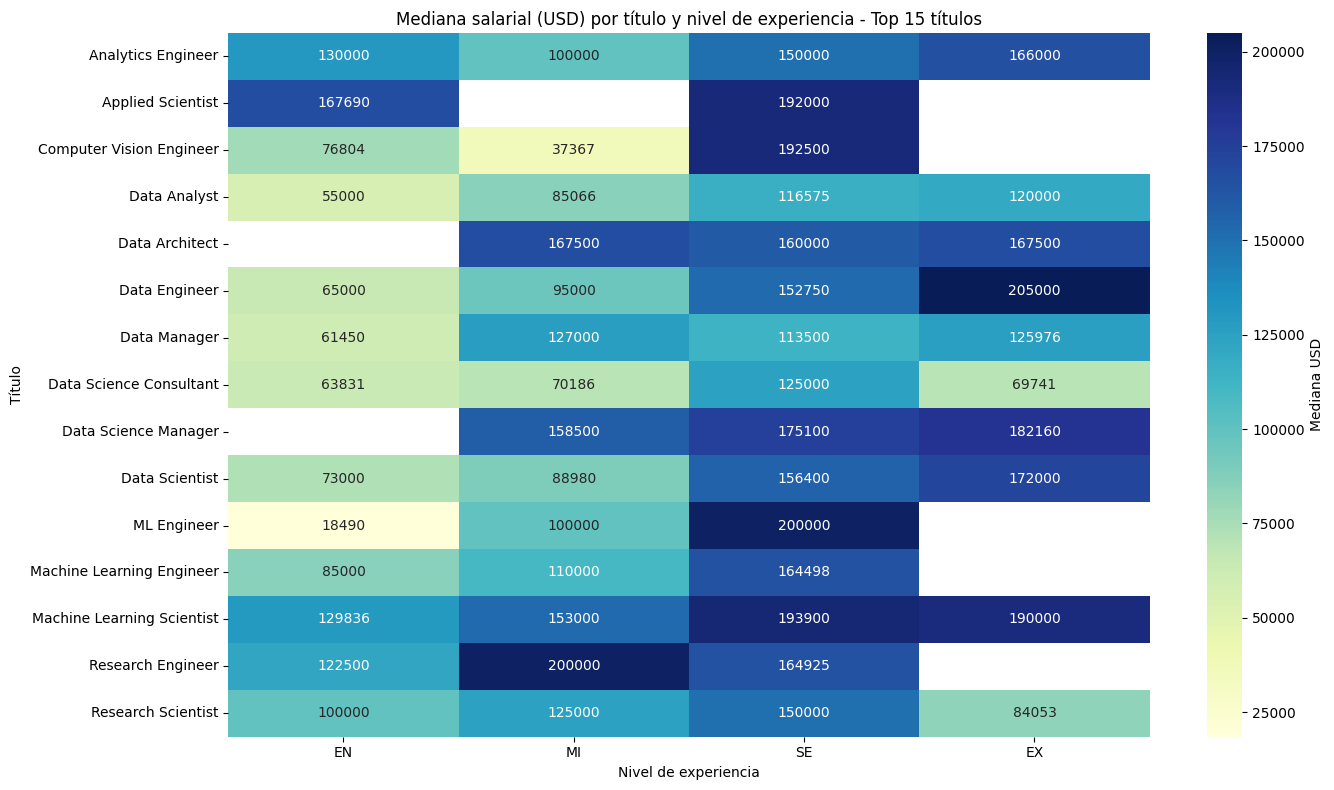

In [19]:
# Pregunta 1) ¿Cómo varía la mediana salarial por título y nivel de experiencia?
## Objetivo: identificar combinaciones job_title × experience_level mejor remuneradas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Tomamos los 15 títulos con más registros para una vista manejable
top_titles = df['job_title'].value_counts().nlargest(15).index.tolist()
df_top = df[df['job_title'].isin(top_titles)].copy()

# Orden lógico de niveles si existen
level_order = ['EN','MI','SE','EX']
if set(level_order).issubset(set(df_top['experience_level'].unique())):
    df_top['experience_level'] = pd.Categorical(df_top['experience_level'], categories=level_order, ordered=True)

# Tabla dinámica de medianas
pivot_med = (df_top
               .groupby(['job_title','experience_level'])['salary_in_usd']
               .median()
               .unstack(fill_value=np.nan))

plt.figure(figsize=(14,8))
sns.heatmap(pivot_med, annot=True, fmt='.0f', cmap='YlGnBu', cbar_kws={'label':'Mediana USD'})
plt.title('Mediana salarial (USD) por título y nivel de experiencia - Top 15 títulos')
plt.xlabel('Nivel de experiencia')
plt.ylabel('Título')
plt.tight_layout()
plt.show()

### Pregunta 2) ¿Existe una “prima remoto” y cambia por seniority?
Objetivo: cuantificar diferencias salariales entre `on-site`, `hybrid`, `remote` y si crecen con la experiencia.

Mediana (USD) por modalidad de trabajo:
 remote_label
on-site    137500.0
remote     130000.0
hybrid      63312.0
Name: salary_in_usd, dtype: float64


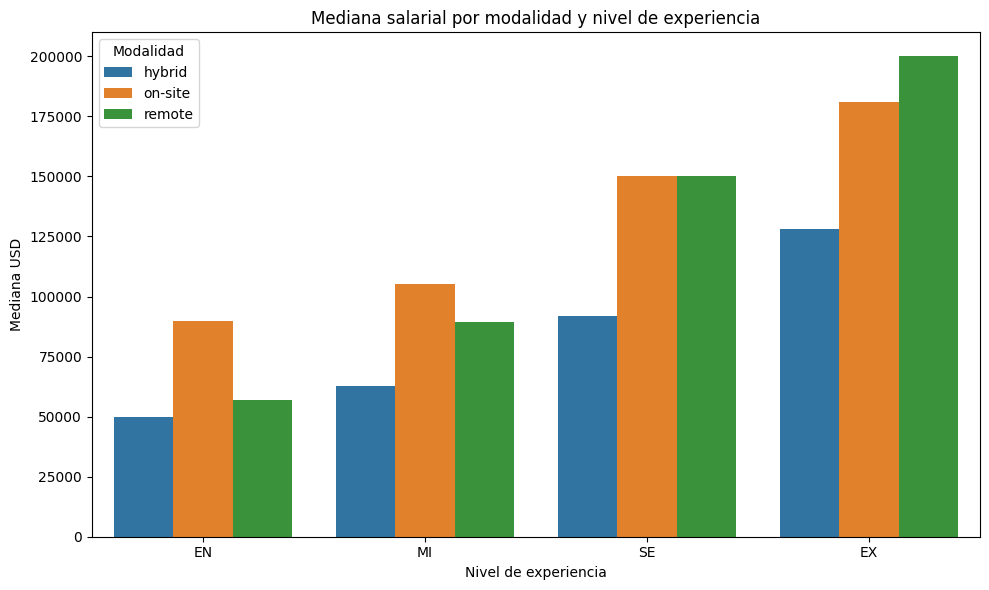

In [20]:
# Mapear remote_ratio a etiquetas
ratio_map = {0: 'on-site', 50: 'hybrid', 100: 'remote'}
df['remote_label'] = df['remote_ratio'].map(ratio_map).fillna('other')

# Mediana global por modalidad
med_global = df.groupby('remote_label')['salary_in_usd'].median().sort_values(ascending=False)
print('Mediana (USD) por modalidad de trabajo:\n', med_global)

# Mediana por modalidad y nivel de experiencia
level_order = ['EN','MI','SE','EX']
df['experience_level'] = pd.Categorical(df['experience_level'], categories=level_order, ordered=True)
med_por_nivel = (df.groupby(['experience_level','remote_label'])['salary_in_usd']
                    .median()
                    .reset_index())

plt.figure(figsize=(10,6))
sns.barplot(data=med_por_nivel, x='experience_level', y='salary_in_usd', hue='remote_label')
plt.title('Mediana salarial por modalidad y nivel de experiencia')
plt.xlabel('Nivel de experiencia')
plt.ylabel('Mediana USD')
plt.legend(title='Modalidad')
plt.tight_layout()
plt.show()

### Pregunta 3) ¿Hay prima transfronteriza?
Objetivo: medir el diferencial cuando `employee_residence != company_location` y si varía por nivel de experiencia.

Mediana (USD) cross-border vs same-country:
 cross_border
same-country    130000.0
cross-border     55108.5
Name: salary_in_usd, dtype: float64


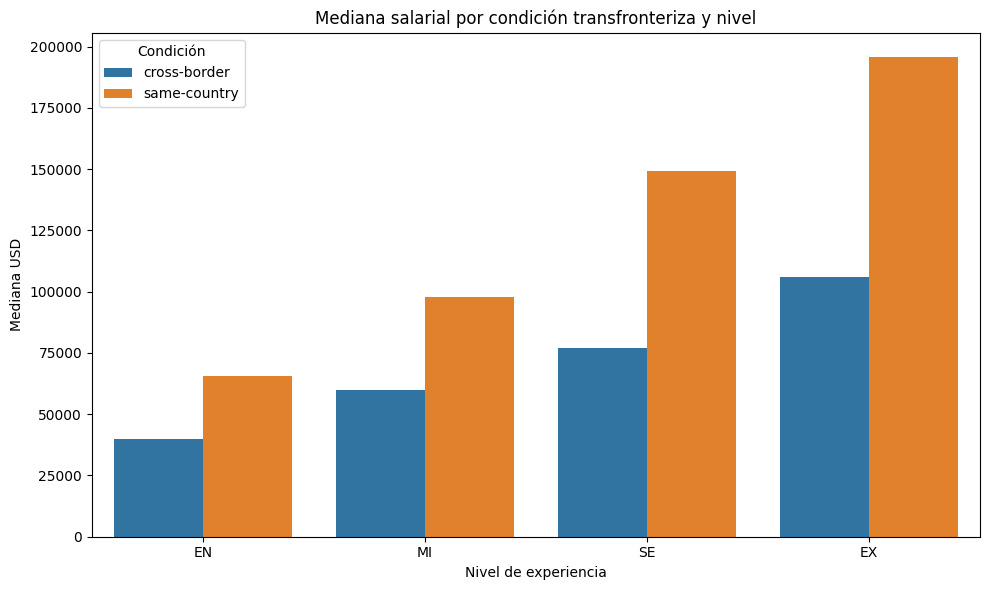

In [21]:
# Flag transfronterizo
df['cross_border'] = np.where(df['employee_residence'] != df['company_location'], 'cross-border', 'same-country')

# Mediana global
med_cb_global = df.groupby('cross_border')['salary_in_usd'].median().sort_values(ascending=False)
print('Mediana (USD) cross-border vs same-country:\n', med_cb_global)

# Mediana por nivel de experiencia
med_cb_nivel = (df.groupby(['experience_level','cross_border'])['salary_in_usd']
                    .median()
                    .reset_index())

plt.figure(figsize=(10,6))
sns.barplot(data=med_cb_nivel, x='experience_level', y='salary_in_usd', hue='cross_border')
plt.title('Mediana salarial por condición transfronteriza y nivel')
plt.xlabel('Nivel de experiencia')
plt.ylabel('Mediana USD')
plt.legend(title='Condición')
plt.tight_layout()
plt.show()

### Pregunta 4) ¿Qué tendencia temporal muestra el salario por nivel?
Objetivo: evaluar crecimiento/estancamiento por año y seniority.

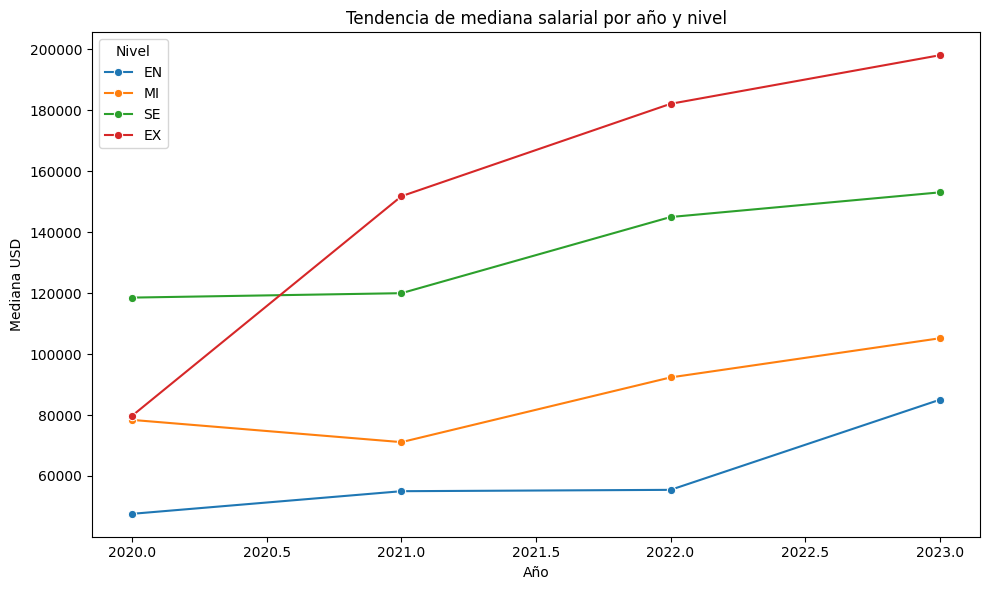

In [22]:
# Mediana por año y nivel
trend = (df.groupby(['work_year','experience_level'])['salary_in_usd']
           .median()
           .reset_index())

plt.figure(figsize=(10,6))
sns.lineplot(data=trend, x='work_year', y='salary_in_usd', hue='experience_level', marker='o')
plt.title('Tendencia de mediana salarial por año y nivel')
plt.xlabel('Año')
plt.ylabel('Mediana USD')
plt.legend(title='Nivel')
plt.tight_layout()
plt.show()

### Pregunta 5) ¿Cómo impacta el tamaño de empresa en el salario por seniority?
Objetivo: comparar `company_size` (S/M/L) dentro de cada `experience_level`.

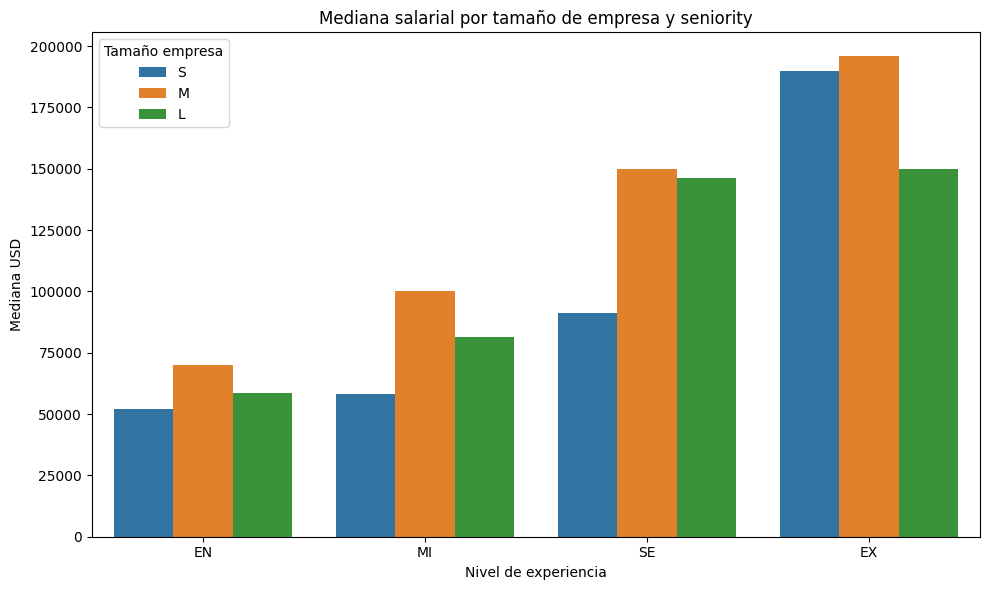

In [23]:
# Mediana por tamaño de empresa y nivel
size_order = ['S','M','L']
df['company_size'] = pd.Categorical(df['company_size'], categories=size_order, ordered=True)
med_size = (df.groupby(['experience_level','company_size'])['salary_in_usd']
              .median()
              .reset_index())

plt.figure(figsize=(10,6))
sns.barplot(data=med_size, x='experience_level', y='salary_in_usd', hue='company_size')
plt.title('Mediana salarial por tamaño de empresa y seniority')
plt.xlabel('Nivel de experiencia')
plt.ylabel('Mediana USD')
plt.legend(title='Tamaño empresa')
plt.tight_layout()
plt.show()

### Pregunta 6) ¿Qué mercados concentran más talento y mejores salarios?
Objetivo: top países por volumen con mediana y p90 de `salary_in_usd`.

  company_location  count  median_usd   p90_usd
9               US   1929    145885.0  230000.0
6               GB    155     80036.0  127874.4
2               CA     83    120000.0  223000.0
7               IN     57     18314.0   58351.8
3               DE     55     71897.0  166456.8
4               ES     44     48289.0   82837.1
5               FR     33     59102.0  106860.4
1               BR     15     42000.0   78000.0
0               AU     14     72525.0  145129.8
8               PT     14     52932.5   72407.5


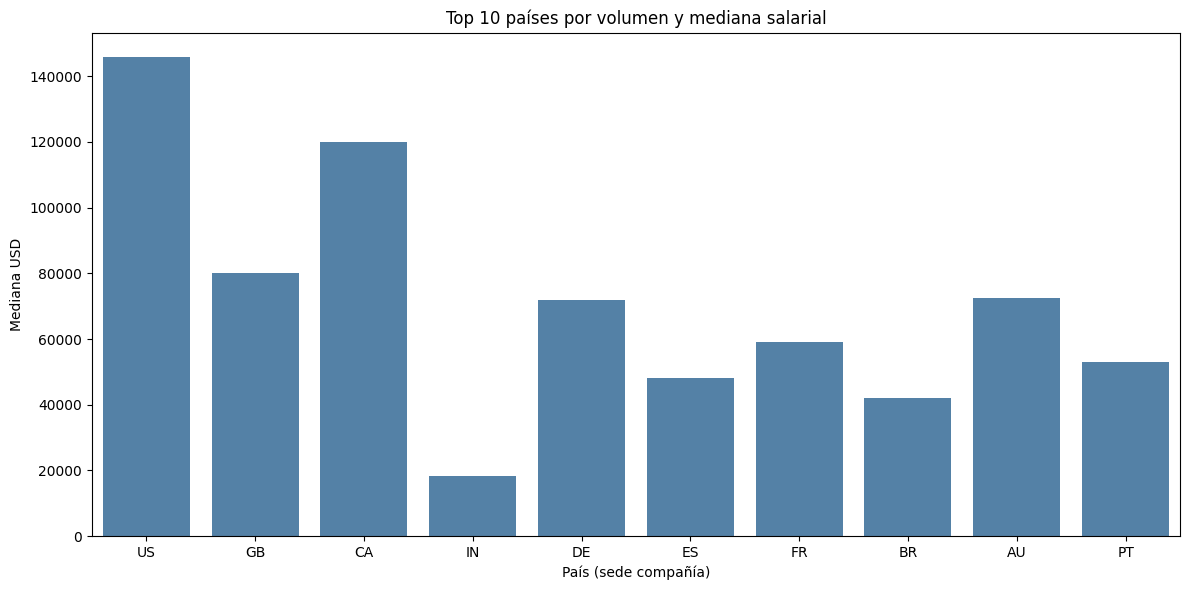

In [24]:
# Top 10 países por volumen y sus métricas salariales
top_countries = df['company_location'].value_counts().nlargest(10).index.tolist()
geo = (df[df['company_location'].isin(top_countries)]
         .groupby('company_location')
         .agg(count=('salary_in_usd','size'),
              median_usd=('salary_in_usd','median'),
              p90_usd=('salary_in_usd', lambda x: np.percentile(x, 90)))
         .reset_index()
         .sort_values('count', ascending=False))
print(geo)

plt.figure(figsize=(12,6))
sns.barplot(data=geo, x='company_location', y='median_usd', color='steelblue')
plt.title('Top 10 países por volumen y mediana salarial')
plt.xlabel('País (sede compañía)')
plt.ylabel('Mediana USD')
plt.tight_layout()
plt.show()

### Pregunta 7) ¿Dónde se concentran los outliers salariales?
Objetivo: calcular tasa de outliers por grupo (usando Isolation Forest si existe, o IQR/Z-score como fallback).

In [25]:
# Usar df_con_outliers si ya fue creado por Isolation Forest; si no, crear flag IQR sobre salary_in_usd
if 'df_con_outliers' in globals():
    base = df_con_outliers.copy()
    base['is_outlier'] = (base['outlier_flag'] == -1)
else:
    base = df.copy()
    q1, q3 = base['salary_in_usd'].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    base['is_outlier'] = (base['salary_in_usd'] < lower) | (base['salary_in_usd'] > upper)

# Tasa de outliers por grupo (ej: título y país de compañía)
grp = (base.groupby(['job_title','company_location'])
           .agg(n=('salary_in_usd','size'),
                outliers=('is_outlier','sum'))
           .assign(rate=lambda x: x['outliers']/x['n'])
           .reset_index()
           .query('n >= 20')
           .sort_values('rate', ascending=False))
grp.head(15)

,job_title,company_location,n,outliers,rate
180,Data Science Manager,US,46,7,0.152174
351,Research Scientist,US,43,5,0.116279
262,ML Engineer,US,28,3,0.107143
295,Machine Learning Engineer,US,137,14,0.102190
41,Applied Scientist,US,31,2,0.064516
125,Data Architect,US,60,3,0.050000
213,Data Scientist,US,396,19,0.047980
313,Machine Learning Scientist,US,21,1,0.047619
148,Data Engineer,US,487,22,0.045175
101,Data Analyst,GB,24,1,0.041667


### Pregunta 8) ¿Qué roles tienen mayor dispersión salarial interna?
Objetivo: medir IQR, desviación estándar y ratio p90/p10 para los 10 títulos con mayor volumen.

In [26]:
# Top 10 títulos por volumen y métricas de dispersión
top10_roles = df['job_title'].value_counts().nlargest(10).index.tolist()
disp = (df[df['job_title'].isin(top10_roles)]
          .groupby('job_title')['salary_in_usd']
          .agg(count='size',
               median='median',
               p10=lambda x: np.percentile(x, 10),
               p90=lambda x: np.percentile(x, 90),
               iqr=lambda x: np.percentile(x, 75) - np.percentile(x, 25),
               std='std')
          .reset_index())
disp['p90_p10_ratio'] = disp['p90'] / disp['p10']
disp.sort_values('iqr', ascending=False)

,job_title,count,median,p10,p90,iqr,std,p90_p10_ratio
6,ML Engineer,34,160000.0,40113.3,252100.0,113375.00,76590.451265,6.284699
9,Research Scientist,65,145900.0,63113.4,248940.0,99782.00,79906.146307,3.944329
7,Machine Learning Engineer,206,145000.0,59109.5,246750.0,91500.00,68295.496545,4.174456
5,Data Scientist,538,132600.0,49893.8,210835.0,88420.75,63935.726042,4.225675
3,Data Engineer,598,135000.0,64670.0,225000.0,86225.00,62168.503059,3.479202
4,Data Science Manager,52,175100.0,107400.0,249084.0,85030.00,59175.832887,2.319218
8,Research Engineer,33,155000.0,100508.8,247600.0,80000.00,57411.534396,2.463466
2,Data Architect,64,163750.0,105590.0,233620.0,72300.00,59798.545770,2.212520
0,Analytics Engineer,91,143860.0,87000.0,214200.0,68850.00,52507.773908,2.462069
1,Data Analyst,396,102920.0,48304.5,169000.0,62237.50,51873.617133,3.498639


### Pregunta 9) ¿Qué títulos muestran mayor crecimiento salarial en el tiempo?
Objetivo: estimar el crecimiento relativo de la mediana entre el primer y el último año disponible por título con suficiente historial.

In [27]:
# Crecimiento de la mediana por título entre primer y último año con datos
min_year = int(df['work_year'].min())
max_year = int(df['work_year'].max())

hist_roles = (df.groupby(['job_title','work_year'])['salary_in_usd']
                .median()
                .unstack())

# Requerir al menos 3 años distintos con datos para estabilidad
enough_years = hist_roles.dropna(axis=0, thresh=3)
enough_years = enough_years.loc[:, [c for c in enough_years.columns if c in [min_year, max_year]]]
enough_years = enough_years.dropna()

enough_years['growth_abs'] = enough_years[max_year] - enough_years[min_year]
enough_years['growth_pct'] = (enough_years['growth_abs'] / enough_years[min_year]) * 100
enough_years.sort_values('growth_pct', ascending=False).head(15)

work_year,2020,2023,growth_abs,growth_pct
job_title,,,,
ML Engineer,15966.0,180000.0,164034.0,1027.395716
AI Scientist,45896.0,231232.5,185336.5,403.818416
Computer Vision Engineer,60000.0,212500.0,152500.0,254.166667
Machine Learning Infrastructure Engineer,50180.0,171600.0,121420.0,241.968912
Data Analyst,34784.0,108000.0,73216.0,210.487580
Data Scientist,62726.0,150000.0,87274.0,139.135287
Data Engineer,72134.5,145000.0,72865.5,101.013385
Data Science Consultant,54353.5,94000.0,39646.5,72.941945
Product Data Analyst,13036.0,16414.0,3378.0,25.912857
